In [1]:
import numpy as np 
import pandas as pd 
import gensim
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

C:\Users\Hai\Anaconda\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\Hai\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Hai\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

data=pd.read_json('data/train.jsonl',lines=True)

data.head()

,context,label,response
0,[A minor child deserves privacy and should be ...,SARCASM,@USER @USER @USER I don't get this .. obviousl...
1,[@USER @USER Why is he a loser ? He's just a P...,SARCASM,@USER @USER trying to protest about . Talking ...
2,[Donald J . Trump is guilty as charged . The e...,SARCASM,@USER @USER @USER He makes an insane about of ...
3,[Jamie Raskin tanked Doug Collins . Collins lo...,SARCASM,@USER @USER Meanwhile Trump won't even release...
4,[Man ... y â€™ all gone â€œ both sides â€� the...,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...


In [7]:
def clean_text(text):
    
    text=text.replace('@USER', "") 
     #Removing <URL>
    text=text.replace('<URL>', "") 
    #Removing 1ormore digits(range 0-9)
    text=text.replace('\d+', '')
    #Converting to lower case
    text=text.lower()
    text=text.replace('[^\w\s]','')
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text


In [8]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    response_lines = list()
    lines = df['response'].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        response_lines.append(words)
    return response_lines



In [10]:
response_lines = CleanTokenize(data)
response_lines[0:10]

[['dont',
  'get',
  'obviously',
  'care',
  'wouldve',
  'moved',
  'right',
  'along',
  'instead',
  'decided',
  'care',
  'troll'],
 ['trying', 'protest', 'talking', 'labels', 'label', 'wtf', 'make', 'em'],
 ['makes', 'insane', 'money', 'movies', 'einstein', 'learnhowthesystemworks'],
 ['meanwhile',
  'trump',
  'wont',
  'even',
  'release',
  'sat',
  'scores',
  'wharton',
  'professors',
  'said',
  'dumbest',
  'student',
  'theyve',
  'ever',
  'taught'],
 ['pretty',
  'sure',
  'antilincoln',
  'crowd',
  'claimed',
  'democracy',
  'ballot',
  'thought',
  'lincoln',
  'authoritarian',
  'gop',
  'partyoflincoln',
  'democrats'],
 ['per', 'tag', 'line', 'never', 'judge', 'book', 'cover'],
 ['excites', 'kill', 'millions'],
 ['oh',
  'look',
  'racist',
  'offering',
  'solidarity',
  'gullible',
  'idiot',
  'whining',
  'racists'],
 ['biggest', 'bullies'],
 ['responds',
  'facts',
  'tossing',
  'frantic',
  'insults',
  'accuses',
  'others',
  'triggered',
  'facts']]

(-0.5, 999.5, 499.5, -0.5)

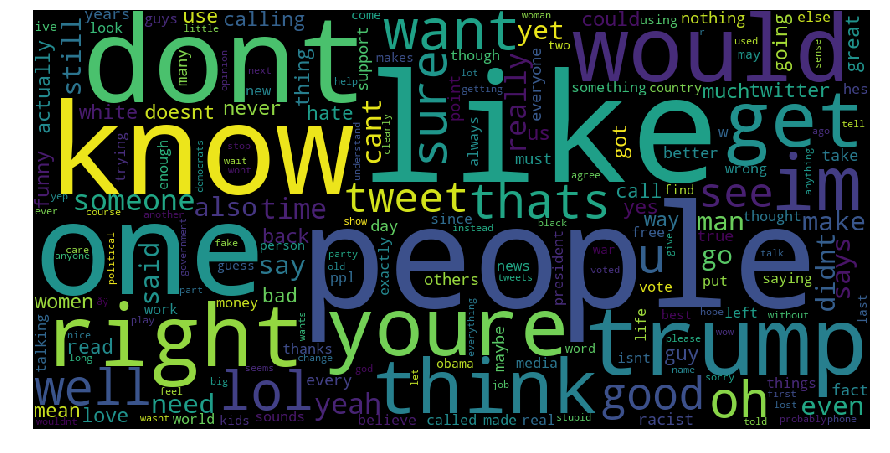

In [11]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['label'] == 'SARCASM']
pos_response_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_response_lines for j in sub] 
word_could_dict=Counter(pos_lines)
# word_could_dict.most_common(10)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [12]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(response_lines)
sequences = tokenizer_obj.texts_to_sequences(response_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])



unique tokens -  12492
vocab size - 12493


In [13]:
sentiment

array(['SARCASM', 'SARCASM', 'NOT_SARCASM', ..., 'SARCASM', 'NOT_SARCASM',
       'SARCASM'], dtype=object)

In [14]:
# encode class values as integers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(sentiment)
encoded_sentiment = encoder.transform(sentiment)

In [15]:
X_train_pad = lines_pad[:-num_validation_samples]
y_train = encoded_sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = encoded_sentiment[-num_validation_samples:]

In [16]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (4000, 25)
Shape of y_train: (4000,)
Shape of X_test_pad: (1000, 25)
Shape of y_test: (1000,)


In [17]:
embeddings_index = {}
embedding_dim = 100

f = open('glove.twitter.27B.100d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

10900


In [19]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [20]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           1249300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,291,605
Trainable params: 42,305
Non-trainable params: 1,249,300
_________________________________________________________________
None


In [21]:
y_train

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [22]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/25
 - 9s - loss: 0.6273 - acc: 0.6405 - val_loss: 0.5513 - val_acc: 0.7350
Epoch 2/25
 - 3s - loss: 0.5693 - acc: 0.7027 - val_loss: 0.5535 - val_acc: 0.7270
Epoch 3/25
 - 3s - loss: 0.5520 - acc: 0.7198 - val_loss: 0.5555 - val_acc: 0.7240
Epoch 4/25
 - 3s - loss: 0.5415 - acc: 0.7250 - val_loss: 0.5475 - val_acc: 0.7160
Epoch 5/25
 - 3s - loss: 0.5362 - acc: 0.7260 - val_loss: 0.5376 - val_acc: 0.7240
Epoch 6/25
 - 4s - loss: 0.5310 - acc: 0.7365 - val_loss: 0.5524 - val_acc: 0.7230
Epoch 7/25
 - 12s - loss: 0.5249 - acc: 0.7370 - val_loss: 0.5441 - val_acc: 0.7100
Epoch 8/25
 - 12s - loss: 0.5180 - acc: 0.7420 - val_loss: 0.5541 - val_acc: 0.7170
Epoch 9/25
 - 11s - loss: 0.5114 - acc: 0.7540 - val_loss: 0.5546 - val_acc: 0.7230
Epoch 10/25
 - 11s - loss: 0.5024 - acc: 0.7552 - val_loss: 0.5463 - val_acc: 0.7230
Epoch 11/25
 - 11s - loss: 0.4987 - acc: 0.7582 - val_loss: 0.5328 - val_acc: 0.7390
Epoch 12/25
 - 12s - loss: 0.482

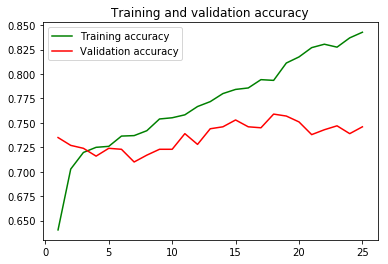

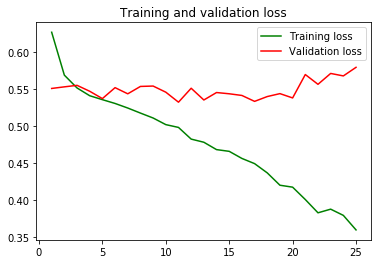

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"response":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "SARCASM" 
    else: return "NOT_SARCASM"

In [25]:
predict_sarcasm("You just broke my car window. Great job.")

'NOT_SARCASM'

In [27]:
predict_sarcasm("You just saved my dog's life. Thanks a million.")

'NOT_SARCASM'

In [28]:
predict_sarcasm("Thanks einstein,wouldn't have figured this out")

'SARCASM'

In [29]:

test=pd.read_json('data/test.jsonl',lines=True)

test.head()

,context,id,response
0,"[Well now that ’ s problematic AF <URL>, @USER...",twitter_1,"@USER @USER @USER My 3 year old , that just fi..."
1,[Last week the Fake News said that a section o...,twitter_2,@USER @USER How many verifiable lies has he to...
2,[@USER Let ’ s Aplaud Brett When he deserves i...,twitter_3,@USER @USER @USER Maybe Docs just a scrub of a...
3,[Women generally hate this president . What's ...,twitter_4,@USER @USER is just a cover up for the real ha...
4,"[Dear media Remoaners , you excitedly sharing ...",twitter_5,@USER @USER @USER The irony being that he even...


In [30]:
response_lines_test = CleanTokenize(test)
response_lines_test[0:10]

[['year',
  'old',
  'finished',
  'reading',
  'nietzsche',
  'asked',
  'ayo',
  'papa',
  'people',
  'always',
  'trying',
  'cancel',
  'someone',
  'twitter',
  'trying',
  'pretend',
  'like',
  'makes',
  'better',
  'replied',
  'idk',
  'cuz',
  'hoes',
  'mad',
  'im',
  'proud'],
 ['many',
  'verifiable',
  'lies',
  'told',
  'documented',
  'hes',
  'truth',
  'teller',
  'sure'],
 ['maybe',
  'docs',
  'scrub',
  'coach',
  'mean',
  'get',
  'hammered',
  'gold',
  'standard',
  'team'],
 ['cover', 'real', 'hate', 'inside', 'left', 'nutshell'],
 ['irony', 'even', 'ask'],
 ['doesnt',
  'matter',
  'guys',
  'werent',
  'athletic',
  'enough',
  'play',
  'todays',
  'nba',
  'know'],
 ['kindnesscascade', 'communities', 'bring', 'teach', 'much', 'wellbeing'],
 ['need', 'msp', 'fm', 'oh', 'byelection', 'oh'],
 ['constitution',
  'written',
  'students',
  'cant',
  'hide',
  'identity',
  'library',
  'using',
  'handkerchief',
  'whilst',
  'cops',
  'controlling',
  'rio

In [32]:
    test_sequences1 = tokenizer_obj.texts_to_sequences(response_lines_test)
    test_review_pad1 = pad_sequences(test_sequences1, maxlen=max_length, padding='post')
    pred1 = model.predict(test_review_pad1)

In [33]:
pred1

array([[0.48987445],
       [0.8927561 ],
       [0.38323057],
       ...,
       [0.31665525],
       [0.16867429],
       [0.05146397]], dtype=float32)

In [34]:
sub=pred1.round()
sub=encoder.inverse_transform(sub.ravel().astype('int16'))
sub=pd.DataFrame(sub,columns=['label'])
sub=pd.concat([test['id'], sub], axis=1)
sub.head()
sub.to_csv('answer.txt',sep=',',index=False,header=None)

C:\Users\Hai\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
